In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
bs=1
lr=0.0002 
beta1=0.5
beta2=0.999
NUM_EPOCHS = 200
ngpu = 1
L1_lambda = 100

# import torch_xla.core.xla_model as xm
# device = xm.xla_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
data_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.CenterCrop((256, 512)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image

# Usage
dataset_train = CustomDataset('/kaggle/input/satelite/maps/train/', transform=data_transform)
dataset_val = CustomDataset('/kaggle/input/satelite/maps/val/', transform=data_transform)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=24, shuffle=True, num_workers=0)


# dataset_train = datasets.ImageFolder(root='/kaggle/input/satelite/maps/train/', transform=data_transform)
# dataset_val = datasets.ImageFolder(root = '/kaggle/input/satelite/maps/val/', transform=data_transform)

# dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=0)
# dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=24, shuffle=True, num_workers=0)

In [4]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load the combined image
        img_path = os.path.join(self.image_dir, self.images[idx])
        combined_image = Image.open(img_path).convert("RGB")
        
        # Split the combined image into satellite and map images
        width, height = combined_image.size
        satellite_image = combined_image.crop((0, 0, width // 2, height))  # Left half for satellite
        map_image = combined_image.crop((width // 2, 0, width, height))   # Right half for map

        if self.transform:
            satellite_image = self.transform(satellite_image)
            map_image = self.transform(map_image)

        return satellite_image, map_image  # Return both images

# Define your transformations
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((256, 256)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Usage
dataset_train = CustomDataset('/kaggle/input/satelite/maps/train/', transform=data_transform)
dataset_val = CustomDataset('/kaggle/input/satelite/maps/val/', transform=data_transform)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=24, shuffle=True, num_workers=0)

In [5]:
print(len(dataset_train))
print(len(dataset_val))

1096
1098


In [6]:
def show_image(img, title="No title", figsize=(5,5)):
    img = img.numpy().transpose(1,2,0)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    img = img * std + mean
    np.clip(img, 0, 1)
    
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.title(title)

In [7]:
satellite_images, map_images = next(iter(dataloader_train))
print(satellite_images.shape)  # Should show shape of your batch of satellite images
print(map_images.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


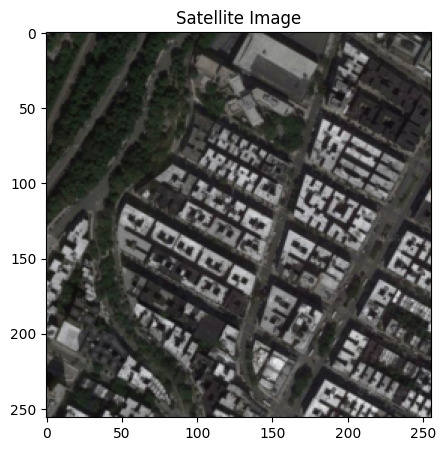

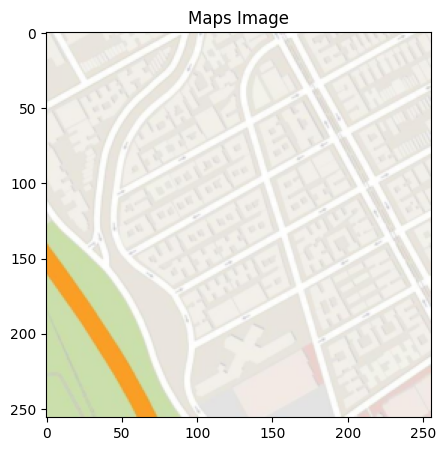

In [8]:
show_image(satellite_images[0], title="Satellite Image", figsize=(5,5))
show_image(map_images[0], title="Maps Image", figsize=(5,5))

In [9]:
def weights_init(m):
    name = m.__class__.__name__
    
    if(name.find("Conv") > -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02) # ~N(mean=0.0, std=0.02)
    elif(name.find("BatchNorm") > -1):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [10]:
"""
    The Generator is a U-Net 256 with skip connections between Encoder and Decoder
"""

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        """
        ===== Encoder ======
        
        * Encoder has the following architecture:
        0) Inp3 
        1) C64 
        2) Leaky, C128, Norm 
        3) Leaky, C256, Norm 
        4) Leaky, C512, Norm 
        5) Leaky, C512, Norm 
        6) Leaky, C512, Norm 
        7) Leaky, C512
        
        * The structure of 1 encoder block is:
        1) LeakyReLU(prev layer)
        2) Conv2D
        3) BatchNorm
        
        Where Conv2D has kernel_size-4, stride=2, padding=1 for all layers
        """
        self.encoder1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)
        
        self.encoder2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128)
        )
        
        self.encoder3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256),
        )
        
        self.encoder4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512)
        )
        
        self.encoder5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512)
        )
        
        self.encoder6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512)
        )
        
        self.encoder7 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        """
        ===== Decoder =====
        * Decoder has the following architecture:
        1) ReLU(from latent space), DC512, Norm, Drop 0.5 - Residual
        2) ReLU, DC512, Norm, Drop 0.5, Residual
        3) ReLU, DC512, Norm, Drop 0.5, Residual
        4) ReLU, DC256, Norm, Residual
        5) ReLU, DC128, Norm, Residual
        6) ReLU, DC64, Norm, Residual
        7) ReLU, DC3, Tanh()
        
        * Note: only apply Dropout in the first 3 Decoder layers
        
        * The structure of each Decoder block is:
        1) ReLU(from prev layer)
        2) ConvTranspose2D
        3) BatchNorm
        4) Dropout
        5) Skip connection
        
        Where ConvTranpose2D has kernel_size=4, stride=2, padding=1
        """
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
            #nn.Dropout(0.5)
        )
        # skip connection in forward()
        
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.5)
        )
        # skip connection in forward()
        
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
            #nn.Dropout(0.5)
        )
        # skip connection in forward()
        
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512*2, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            #nn.Dropout(0.5)
        )
        
        self.decoder5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256*2, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.5)
        )
        
        self.decoder6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128*2, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.5)
        )
        
        self.decoder7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64*2, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Tanh()
        )
    
    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        e6 = self.encoder6(e5)
        
        latent_space = self.encoder7(e6)
        
        d1 = torch.cat([self.decoder1(latent_space), e6], dim=1)
        d2 = torch.cat([self.decoder2(d1), e5], dim=1)
        d3 = torch.cat([self.decoder3(d2), e4], dim=1)
        d4 = torch.cat([self.decoder4(d3), e3], dim=1)
        d5 = torch.cat([self.decoder5(d4), e2], dim=1)
        d6 = torch.cat([self.decoder6(d5), e1], dim=1)
        
        out = self.decoder7(d6)
        
        return out

In [11]:
model_G = Generator(ngpu=1)

if(device == "cuda" and ngpu > 1):
    model_G = nn.DataParallel(model_G, list(range(ngpu)))
    
model_G.apply(weights_init)
model_G.to(device)

Generator(
  (encoder1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder5): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False

In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        
        self.structure = nn.Sequential(
            nn.Conv2d(in_channels=3*2, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.structure(x)

In [13]:
model_D = Discriminator(ngpu=1)

if(device == "cuda" and ngpu>1):
    model_D = torch.DataParallel(model_D, list(rang(ngpu)))
    
model_D.apply(weights_init)
model_D.to(device)

Discriminator(
  (structure): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [14]:
satellite_image,maps_image = next(iter(dataloader_train))
x = torchvision.utils.make_grid(satellite_image, padding=10)
y = torchvision.utils.make_grid(maps_image, padding=10)

In [15]:
satellite_image

tensor([[[[-0.0902,  0.0039, -0.1059,  ..., -0.8039, -0.7961, -0.7804],
          [-0.0745, -0.0824, -0.2863,  ..., -0.8118, -0.7804, -0.7176],
          [ 0.0275,  0.0745, -0.1216,  ..., -0.8118, -0.7882, -0.7882],
          ...,
          [-0.2863, -0.6392, -0.7412,  ..., -0.7961, -0.7882, -0.7725],
          [ 0.0353, -0.4510, -0.6784,  ..., -0.8039, -0.7961, -0.7804],
          [ 0.2471, -0.2000, -0.6706,  ..., -0.8118, -0.8039, -0.7882]],

         [[-0.0980, -0.0039, -0.1137,  ..., -0.7725, -0.7804, -0.7647],
          [-0.0824, -0.0902, -0.2941,  ..., -0.7882, -0.7647, -0.7020],
          [ 0.0196,  0.0667, -0.1294,  ..., -0.7882, -0.7725, -0.7804],
          ...,
          [-0.2863, -0.6392, -0.7412,  ..., -0.7255, -0.7333, -0.7333],
          [ 0.0431, -0.4510, -0.6784,  ..., -0.7333, -0.7412, -0.7412],
          [ 0.2471, -0.2000, -0.6706,  ..., -0.7412, -0.7490, -0.7490]],

         [[-0.1294, -0.0353, -0.1451,  ..., -0.8196, -0.8196, -0.8039],
          [-0.1137, -0.1216, -

In [16]:
out1 = model_D(torch.cat([satellite_image.to(device), maps_image.to(device)], dim=1)).to(device)
out2 = torch.ones(size=out1.shape, dtype=torch.float, device=device)
criterion = nn.BCELoss()

print(out1.shape)
print(criterion(out1, out2))

torch.Size([1, 1, 30, 30])
tensor(0.8408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [17]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(model_D.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(model_G.parameters(), lr=lr, betas=(beta1, beta2))

NUM_EPOCHS=171
model_D.to(device)
model_G.to(device)
print()

In [18]:
L1_lambda = 100
NUM_EPOCHS= 50

In [19]:
for epoch in range(NUM_EPOCHS+1):
    print(f"Training epoch {epoch+1}")
    for satellite_image,maps_image in iter(dataloader_train):
        model_D.zero_grad()
        
        inputs = satellite_image.to(device) # input image data
        targets = maps_image.to(device) # real targets data
        
        real_data = torch.cat([inputs, targets], dim=1).to(device)
        outputs = model_D(real_data) # label "real" data
        labels = torch.ones(size = outputs.shape, dtype=torch.float, device=device)
        
        lossD_real = 0.5 * criterion(outputs, labels) # divide the objective by 2 -> slow down D
        lossD_real.backward()
        
        # Train on fake data
        # Maximize log(1-D(x,G(x))) <- minimize D(x,G(x))
        gens = model_G(inputs).detach()
         
        fake_data = torch.cat([inputs, gens], dim=1) # generated image data
        outputs = model_D(fake_data)
        labels = torch.zeros(size = outputs.shape, dtype=torch.float, device=device) # label "fake" data
        
        lossD_fake = 0.5 * criterion(outputs, labels) # divide the objective by 2 -> slow down D
        lossD_fake.backward()
        
        optimizerD.step()
        
        for i in range(2):
            model_G.zero_grad()
            
            gens = model_G(inputs)
            
            gen_data = torch.cat([inputs, gens], dim=1) # concatenated generated data
            outputs = model_D(gen_data)
            labels = torch.ones(size = outputs.shape, dtype=torch.float, device=device)
            
            lossG = criterion(outputs, labels) + L1_lambda * torch.abs(gens-targets).sum()
            lossG.backward()
            optimizerG.step()
            
    if(epoch%5==0):
        torch.save(model_G, "./sat2mapGen_v1.3.pth")
        torch.save(model_D, "./sat2mapDisc_v1.3.pth")
    
print("Done!")

Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
Training epoch 11
Training epoch 12
Training epoch 13
Training epoch 14
Training epoch 15
Training epoch 16
Training epoch 17
Training epoch 18
Training epoch 19
Training epoch 20
Training epoch 21
Training epoch 22
Training epoch 23
Training epoch 24
Training epoch 25
Training epoch 26
Training epoch 27
Training epoch 28
Training epoch 29
Training epoch 30
Training epoch 31
Training epoch 32
Training epoch 33
Training epoch 34
Training epoch 35
Training epoch 36
Training epoch 37
Training epoch 38
Training epoch 39
Training epoch 40
Training epoch 41
Training epoch 42
Training epoch 43
Training epoch 44
Training epoch 45
Training epoch 46
Training epoch 47
Training epoch 48
Training epoch 49
Training epoch 50
Training epoch 51
Done!


In [20]:
def show_predictions(num_samples):
    for i in range(num_samples):
        test_satellite,test_map = next(iter(dataloader_val))

        image, mask = test_sattelite, test_map
        predicted = generator.predict(tf.expand_dims(image, axis=0))[0]
        
        plt.figure(figsize=(10,8))
        
        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("Satellite Image " + str(i + 1))
        plt.axis('off')
        
        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.title("Map Image " + str(i + 1))
        plt.axis('off')
        
        plt.subplot(1,3,3)
        plt.imshow(predicted)
        plt.title("Predicted Image " + str(i + 1))
        plt.axis('off')
        
        plt.show()

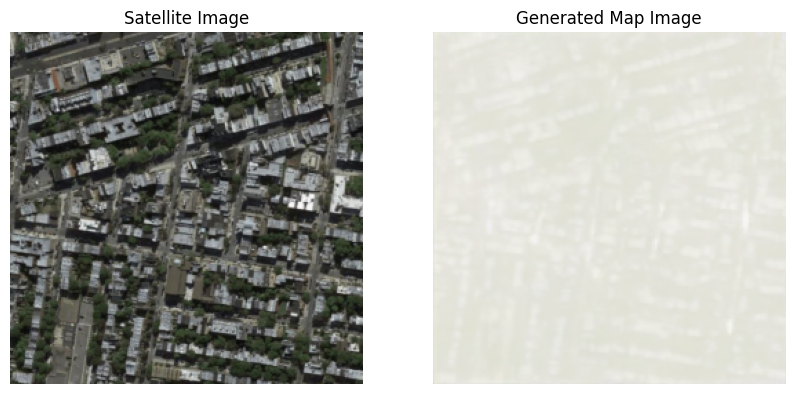

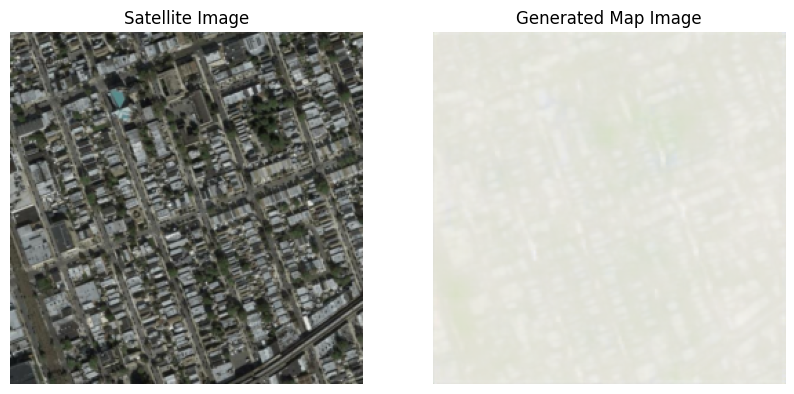

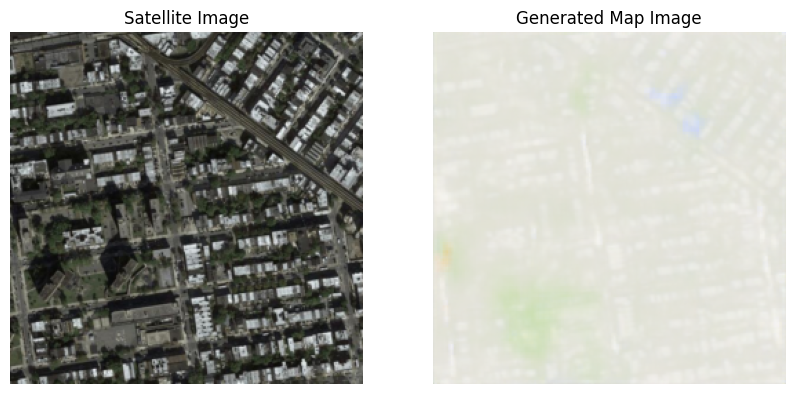

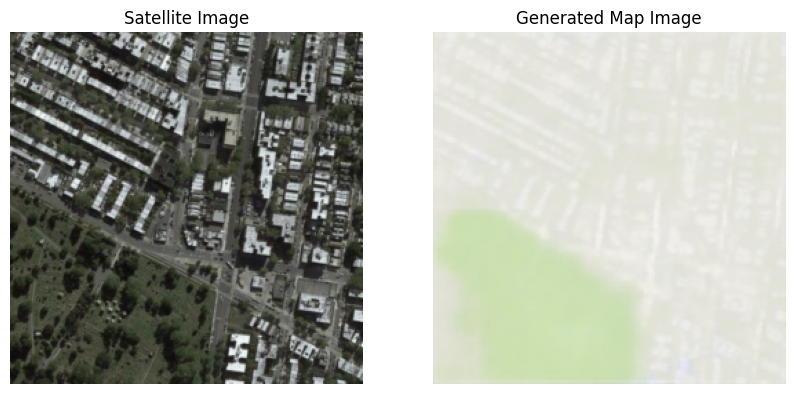

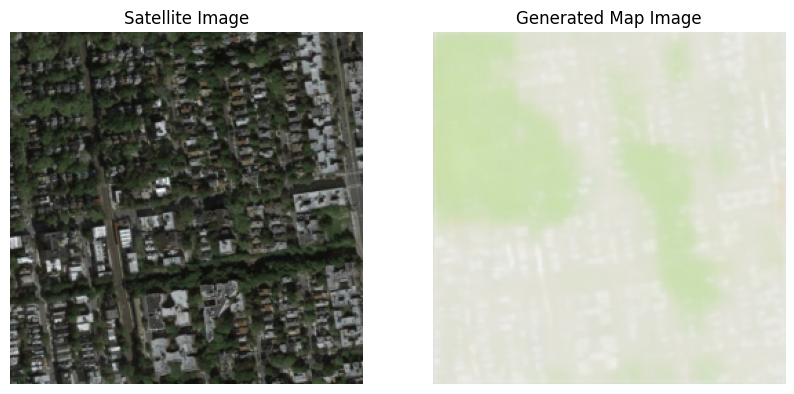

In [21]:
import random

# Function to generate and display five random images
def generate_and_display_random_images(dataloader, model_G, num_images=5):
    model_G.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        # Get a random sample of images from the dataloader
        indices = random.sample(range(len(dataloader.dataset)), num_images)
        for idx in indices:
            satellite_image, _ = dataloader.dataset[idx]  # Get a single satellite image
            satellite_image = satellite_image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU
            
            # Generate the map image using the generator
            generated_map = model_G(satellite_image)
            
            # Convert images to numpy for visualization
            satellite_image = satellite_image.cpu().numpy().squeeze()  # Remove batch dimension
            generated_map = generated_map.cpu().numpy().squeeze()  # Remove batch dimension

            # Check if the images have 3 channels
            if satellite_image.shape[0] == 3:
                satellite_image = satellite_image.transpose(1, 2, 0)  # Convert to HWC
            if generated_map.shape[0] == 3:
                generated_map = generated_map.transpose(1, 2, 0)  # Convert to HWC

            # Normalize the images
            mean = np.array([0.5, 0.5, 0.5])
            std = np.array([0.5, 0.5, 0.5])
            satellite_image = satellite_image * std + mean
            generated_map = generated_map * std + mean

            # Clip the values to be in the range [0, 1]
            satellite_image = np.clip(satellite_image, 0, 1)
            generated_map = np.clip(generated_map, 0, 1)

            # Plot the images
            plt.figure(figsize=(10, 5))
            
            plt.subplot(1, 2, 1)
            plt.imshow(satellite_image)
            plt.title('Satellite Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(generated_map)
            plt.title('Generated Map Image')
            plt.axis('off')

            plt.show()

# Call the function to generate and display random images
generate_and_display_random_images(dataloader_val, model_G, num_images=5)

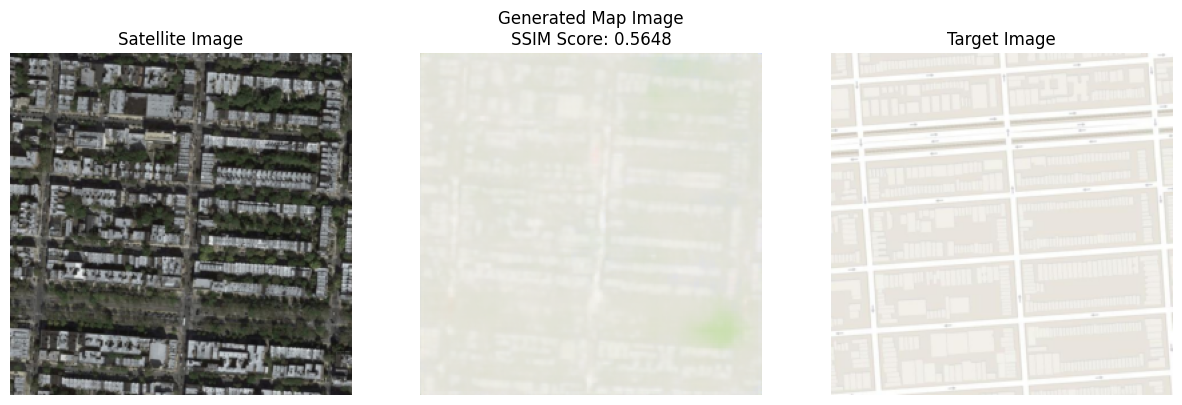

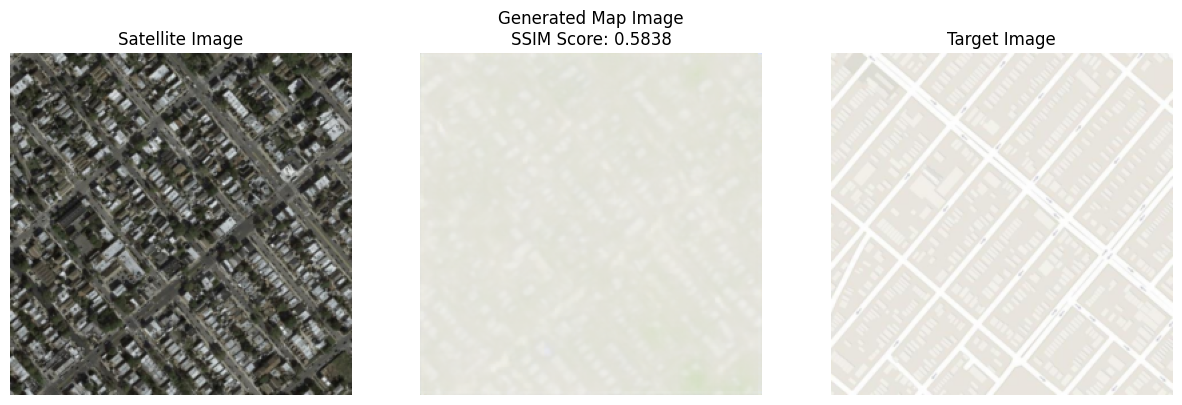

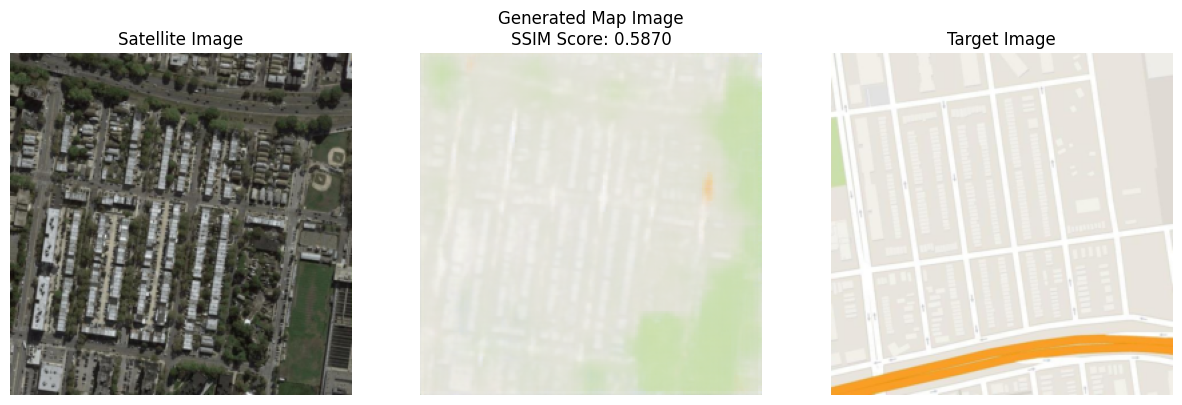

In [23]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from skimage.metrics import structural_similarity as ssim
import cv2

# Function to calculate SSIM
def calculate_ssim(imageA, imageB):
    # Ensure the images are in the range [0, 255] and convert to uint8
    imageA = (imageA * 255).astype(np.uint8)
    imageB = (imageB * 255).astype(np.uint8)
    
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    score, _ = ssim(grayA, grayB, full=True)
    return score

# Function to generate and display five random images
def generate_and_display_random_images(dataloader, model_G, num_images=5):
    model_G.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        # Get a random sample of indices from the dataloader
        indices = random.sample(range(len(dataloader.dataset)), num_images)
        for idx in indices:
            satellite_image, target_image = dataloader.dataset[idx]  # Get a single satellite and target image
            satellite_image = satellite_image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU
            
            # Generate the map image using the generator
            generated_map = model_G(satellite_image)
            
            # Convert images to numpy for visualization
            satellite_image = satellite_image.cpu().numpy().squeeze()  # Remove batch dimension
            generated_map = generated_map.cpu().numpy().squeeze()  # Remove batch dimension
            target_image = target_image.cpu().numpy().squeeze()  # Remove batch dimension

            # Check if the images have 3 channels
            if satellite_image.shape[0] == 3:
                satellite_image = satellite_image.transpose(1, 2, 0)  # Convert to HWC
            if generated_map.shape[0] == 3:
                generated_map = generated_map.transpose(1, 2, 0)  # Convert to HWC
            if target_image.shape[0] == 3:
                target_image = target_image.transpose(1, 2, 0)  # Convert to HWC

            # Normalize the images
            mean = np.array([0.5, 0.5, 0.5])
            std = np.array([0.5, 0.5, 0.5])
            satellite_image = satellite_image * std + mean
            generated_map = generated_map * std + mean
            target_image = target_image * std + mean

            # Clip the values to be in the range [0, 1]
            satellite_image = np.clip(satellite_image, 0, 1)
            generated_map = np.clip(generated_map, 0, 1)
            target_image = np.clip(target_image, 0, 1)

            # Calculate similarity score (SSIM) between generated and target images
            ssim_score = calculate_ssim(generated_map, target_image)

            # Plot the images
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.imshow(satellite_image)
            plt.title('Satellite Image')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(generated_map)
            plt.title('Generated Map Image\nSSIM Score: {:.4f}'.format(ssim_score))
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(target_image)
            plt.title('Target Image')
            plt.axis('off')

            plt.show()

# Call the function to generate and display random images
generate_and_display_random_images(dataloader_val, model_G, num_images=5)